# Detector

## Imports

In [4]:
from itertools import chain
from tqdm import tqdm
import joblib

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from sklearn.feature_extraction.image import PatchExtractor

from skimage import data, color, feature
from skimage.transform import resize, rescale
from skimage.exposure import equalize_hist
from skimage.transform import integral_image
from skimage.feature import haar_like_feature, haar_like_feature_coord

## Clasificador

#### Notas clase
Random forest ordena las variables por importancia. Es otra forma de ordenar las mejores features.

Por ej. corremos el random forest con todas las features y hacemos el variable importance y vemos que decrece mucho y solo las 1era 100 importan.

Tomamos las 100 features y reentrenamos el modelo con esas 100 features. No va a cambiar mucho la exactitud.

Aca se asume que ya seleccionamos el modelo y las features que se usan.

Este detector es un extra. La idea es que podamos cambiar la imagend el astronauta por lo que queramos

In [30]:
f_idx = np.loadtxt('f_idx.txt', dtype = int)

In [31]:
f_idx

array([ 1162,  2719, 10049, 20882, 26539, 33049, 35702, 37295, 45396,
       45570, 45787, 48335, 56947, 63569])

In [32]:
clf = joblib.load("clf.pkl")

## Funciones auxiliares

In [7]:
def extract_feature_image(img, feature_type=None, feature_coord=None):
    """Extrae las Haar features de la imagen"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

In [8]:
def non_max_suppression(indices, Ni, Nj, overlapThresh):
    # Si no hay rectángulos, regresar una lista vacía
    if len(indices) == 0:
        return []

    # Si las cajas son enteros, convertir a flotantes
    if indices.dtype.kind == "i":
        indices = indices.astype("float")

    # Inicializar la lista de índices seleccionados
    pick = []

    # Tomar las coordenadas de los cuadros
    x1 = np.array([indices[i,0] for i in range(indices.shape[0])])
    y1 = np.array([indices[i,1] for i in range(indices.shape[0])])
    x2 = np.array([indices[i,0]+Ni for i in range(indices.shape[0])])
    y2 = np.array([indices[i,1]+Nj for i in range(indices.shape[0])])

    # Calcula el área de los cuadros y ordena los cuadros
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # Mientras todavía hay índices en la lista de índices
    while len(idxs) > 0:
        # Toma el último índice de la lista y agrega el índice a la lista de seleccionados
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Encontrar las coordenadas (x, y) más grandes para el inicio de la caja y las coordenadas (x, y) más pequeñas para el final de la caja
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Calcula el ancho y alto de la caja
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Calcula la proporción de superposición
        overlap = (w * h) / area[idxs[:last]]

        # Elimina todos los índices del índice de lista que tienen una proporción de superposición mayor que el umbral proporcionado
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Devuelve solo las cajas seleccionadas
    return indices[pick].astype("int")

In [9]:
# Define una función para realizar una ventana deslizante (sliding window) sobre una imagen.
def sliding_window(img,
                   patch_size=(19,19),  # Define el tamaño del parche (patch) basado en el primer parche positivo por defecto
                   istep=2,  # Paso de desplazamiento en la dirección i (verticalmente)
                   jstep=2,  # Paso de desplazamiento en la dirección j (horizontalmente)
                   scale=1.0):  # Factor de escala para ajustar el tamaño del parche

    # Calcula las dimensiones Ni y Nj del parche ajustadas por el factor de escala.
    Ni, Nj = (int(scale * s) for s in patch_size)

    # Itera a lo largo de la imagen en la dirección i
    for i in range(0, img.shape[0] - Ni, istep):
        # Itera a lo largo de la imagen en la dirección j
        for j in range(0, img.shape[1] - Ni, jstep):

            # Extrae el parche de la imagen usando las coordenadas actuales i, j.
            patch = img[i:i + Ni, j:j + Nj]

            # Si el factor de escala es diferente de 1, redimensiona el parche al tamaño original del parche.
            if scale != 1:
                patch = resize(patch, patch_size)

            # Usa yield para devolver las coordenadas actuales y el parche.
            # Esto convierte la función en un generador.
            yield (i, j), patch

In [10]:
# Función que devuelve el número de detecciones brutas y procesadas para diversas escalas
def detections_by_scale(test_image, test_scales, step, clf, f_idx, size=(19,19), thresholds=[0.5]):
    raw_detections = []
    detections = []

    feature_coord, feature_type = haar_like_feature_coord(width=19,height=19)

    for scale in tqdm(test_scales):
        raw_detections_scale = []
        detections_scale = []

        # Ventana deslizante
        indices, patches = zip(*sliding_window(test_image, scale=scale, istep=step, jstep=step))

        # Calcula las Haar para cada parche y las almacena en un array.
        patches_haar = np.array([extract_feature_image(patch,
                                                      feature_coord=feature_coord[f_idx],
                                                      feature_type=feature_type[f_idx])
                                                      for patch in patches])
        # Predicción
        for thr in thresholds:
            labels = (clf.predict_proba(patches_haar)[:,1]>=thr).astype(int)
            raw_detections_scale.append(labels.sum())
            Ni, Nj = (int(scale*s) for s in size)
            indices = np.array(indices)
            detecciones = indices[labels == 1]
            detecciones = non_max_suppression(np.array(detecciones),Ni,Nj, 0.3)
            detections_scale.append(len(detecciones))
        
        # Actualizamos las listas
        raw_detections.append(raw_detections_scale)
        detections.append(detections_scale)
        
    return np.array(raw_detections), np.array(detections)

## Test en la imagen del astronauta

In [13]:
# Imagen de prueba
test_image = data.astronaut()
test_image = color.rgb2gray(test_image)
test_image = rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
test_image = rescale(test_image, 0.5)

In [14]:
test_image.shape

(80, 70)

In [16]:
size = (19,19)

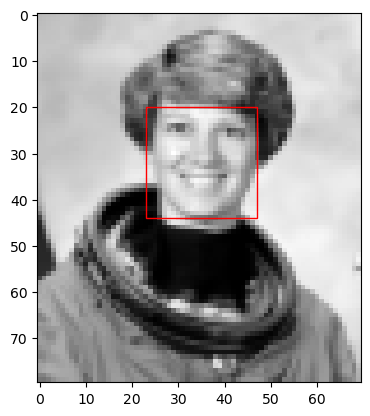

In [56]:
# Visualizamos la imagen
# Buscamos la escala de los rostros
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')

true_scale = 1.3 # En que escala se encuentra el rostro
Ni, Nj = (int(true_scale * s) for s in size)

ax.add_patch(plt.Rectangle((23, 20), Nj, Ni, edgecolor='red', alpha=1, lw=1, facecolor='none'))
plt.show()

In [57]:
# Utiliza la función de ventana deslizante en una imagen de prueba.
# zip(*...) toma las tuplas generadas y las descompone en índices y parches.
indices, patches = zip(*sliding_window(test_image, scale=true_scale))

# Haar feature coordinates
feature_coord, feature_type = haar_like_feature_coord(width=size[0],height=size[1])

# Calcula las Haar para cada parche y las almacena en un array.
patches_haar = np.array([extract_feature_image(patch,
                                               feature_coord=feature_coord[f_idx],
                                               feature_type=feature_type[f_idx])
                                               for patch in patches])

# Muestra la forma del array de características HOG.
patches_haar.shape

(644, 14)

### Desempeño según umbrales

In [64]:
# Predicción

# Hago predicciones con distintos umbrales. El por defecto es 0.5.
# La idea de esto es para poder probar con los datos de test y ver que umbral es el mejor.

# Umbral default
labels_default = clf.predict(patches_haar).astype(int)

# Umbral chico
thrmin = 0.1
labels_optimo = (clf.predict_proba(patches_haar)[:,1]>=thrmin).astype(int) # Que me diga que es rostro si es mas grande que un umbral.

# Umbral grande
thrmax = 0.8
labels_adecuado = (clf.predict_proba(patches_haar)[:,1]>=thrmax).astype(int)

In [65]:
# Procesamiento de las detecciones
Ni, Nj = (int(true_scale*s) for s in size)
indices = np.array(indices)

# Umbral default
detecciones_default = indices[labels_default == 1]
detecciones_default = non_max_suppression(np.array(detecciones_default),Ni,Nj, 0.1)

# Umbral optimo
detecciones_optimo = indices[labels_optimo == 1]
detecciones_optimo = non_max_suppression(np.array(detecciones_optimo),Ni,Nj, 0.1)

# Umbral adecuado
detecciones_adecuado = indices[labels_adecuado == 1]
detecciones_adecuado = non_max_suppression(np.array(detecciones_adecuado),Ni,Nj, 0.1)

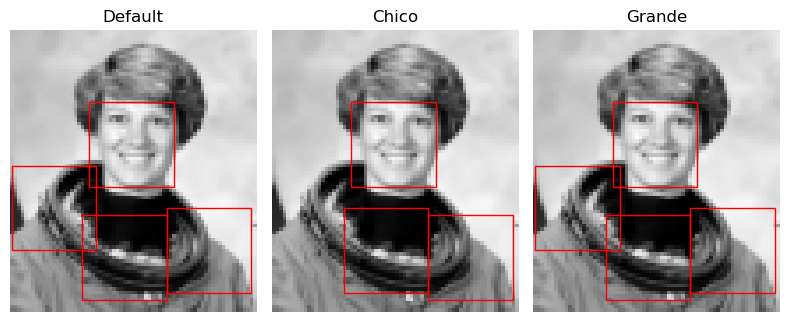

In [66]:
# Visualizamos las detecciones
fig, ax = plt.subplots(1,3, figsize=(8,4))

# Umbral default
ax[0].imshow(test_image, cmap='gray')
ax[0].axis('off')

for i, j in detecciones_default:
    ax[0].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

ax[0].set_title('Default')

# Umbral óptimo
ax[1].imshow(test_image, cmap='gray')
ax[1].axis('off')

for i, j in detecciones_optimo:
    ax[1].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

ax[1].set_title('Chico')

# Umbral adecuado
ax[2].imshow(test_image, cmap='gray')
ax[2].axis('off')

for i, j in detecciones_adecuado:
    ax[2].add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=1, lw=1, facecolor='none'))

ax[2].set_title('Grande')

plt.tight_layout()
plt.show()

### Desempeño en varias escalas según umbral

In [71]:
# Escalas a testear
test_scales = np.linspace(0.125, 2, 20)

In [72]:
raw_detections, detections = detections_by_scale(
    test_image, 
    test_scales,
    2,
    clf,
    f_idx,
    size=(19,19),
    thresholds=[0.5, 0.1, 0.8]
    )

100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


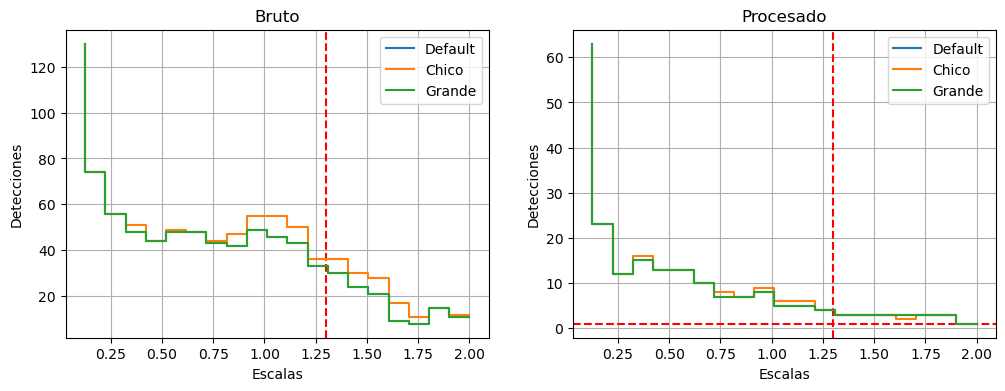

In [76]:
number_faces = 1

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].set_title('Bruto')
ax[0].axvline(x=true_scale, ls = '--', color='red')
ax[0].step(test_scales, raw_detections[:,0], label = 'Default')
ax[0].step(test_scales, raw_detections[:,1], label = 'Chico')
ax[0].step(test_scales, raw_detections[:,2], label = 'Grande')
ax[0].grid(True)
ax[0].set_xlabel('Escalas')
ax[0].set_ylabel('Detecciones')
ax[0].legend()

ax[1].set_title('Procesado')
ax[1].axvline(x=true_scale, ls = '--', color='red')
ax[1].axhline(y=number_faces, ls = '--', color='red')
ax[1].step(test_scales, detections[:,0], label = 'Default')
ax[1].step(test_scales, detections[:,1], label = 'Chico')
ax[1].step(test_scales, detections[:,2], label = 'Grande')
ax[1].grid(True)
ax[1].set_xlabel('Escalas')
ax[1].set_ylabel('Detecciones')
ax[1].legend()
plt.show()